In [1]:
import sys
from functools import partial
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from scipy.special import expit, softplus
from typing import Callable

project_root = Path.cwd().parent
sys.path.append(str(project_root))

from scipy.special import expit, softplus

from src.utils.utils_feature_comparison import (
    define_base_function,
    plot_best_fit,
    single_feature_performance,
)
from src.utils.utils_viz import NotebookFigureSaver
from src.constants import ALGORITHM_PERFORMANCE_PATH

## Feature Selection via Single-Feature Training

To determine the most informative meta-features, the same base neural network architecture that is employed in all uncertainty quantification (UQ) experiments was used for this analysis. 

For the feature selection step, this base network was trained once per individual feature, i.e., each meta-feature served as the sole input feature in a separate training run while keeping all other hyperparameters and training conditions fixed. After training, the Gaussian Negative Log-Likelihood (NLL) on the test data was computed for each run, and the feature corresponding to the lowest NLL was identified as the most predictive single feature.  


In [18]:
test_algorithm_file = "ROCKET_ACC.csv"
df_feature_comparison = single_feature_performance(test_algorithm_file)


# Define Base Function
In this step, a base function is derived to model the relationship between the best performing meta-feature from the previous step and the target metric (e.g., mean accuracy or std accuracy).

Several candidate functions (linear, quadratic, cubic, exponential, sinusoidal) are fitted to the scaled feature values, and the one with the lowest MAE is selected. The resulting 1-D base function serves as a simple yet realistic approximation of how performance behaves with respect to a single meta-feature, forming the foundation for subsequent experiments.

In [19]:
import os
import pandas as pd
import numpy as np

# Ordner mit deinen CSV-Dateien
folder = ALGORITHM_PERFORMANCE_PATH
results_summary = {}
for file in sorted(os.listdir(folder)):
    if not file.endswith(".csv"):
        continue

    algo_name = os.path.splitext(file)[0]  # z.B. "BBB_results"
    path = os.path.join(folder, file)

    # Datei einlesen
    df = pd.read_csv(path, header=None)
    dataset_names = df.iloc[:, 0]
    values = df.iloc[1:, 1:].apply(pd.to_numeric, errors="coerce")

    # STD pro Datensatz (Zeile)
    std_per_row = values.std(axis=1, ddof=0)

    # Mean der STDs (über alle Datasets)
    mean_std = std_per_row.mean()
    results_summary[algo_name] = mean_std

    # Optional: Details für Debugging
    #print(f"\n📘 {algo_name}")


# 🔚 Gesamtergebnis über alle Algorithmen
print("\n===============================")
print("📊 Summary: Mean STD per algorithm")
print("===============================")
for algo, mean_std in results_summary.items():
    print(f"{algo:<25} {mean_std:.4f}")


📊 Summary: Mean STD per algorithm
1NN-DTW_ACC               0.0234
Arsenal_ACC               0.0197
BOSS_ACC                  0.0236
CIF_ACC                   0.0223
CNN_ACC                   0.0356
Catch22_ACC               0.0247
DrCIF_ACC                 0.0211
EE_ACC                    0.0244
FreshPRINCE_ACC           0.0216
HC1_ACC                   0.0191
HC2_ACC                   0.0183
Hydra-MR_ACC              0.0189
Hydra_ACC                 0.0189
InceptionT_ACC            0.0232
Mini-R_ACC                0.0189
MrSQM_ACC                 0.0227
Multi-R_ACC               0.0187
PF_ACC                    0.0220
RDST_ACC                  0.0187
RISE_ACC                  0.0240
RIST_ACC                  0.0188
ROCKET_ACC                0.0196
RSF_ACC                   0.0259
RSTSF_ACC                 0.0208
ResNet_ACC                0.0304
STC_ACC                   0.0256
STSF_ACC                  0.0229
ShapeDTW_ACC              0.0248
Signatures_ACC            0.0247
TDE_ACC 

In [20]:
# Choose target metric: "std_accuracy" or "mean_accuracy"
target = "std_accuracy"
target = "mean_accuracy"

def _apply(func: Callable, 
           x: np.ndarray, 
           a: float, 
           b: float, 
           c: float, 
           d: float, 
           e: float, 
           activation: Callable):
     """Apply a base function with given parameters and activation."""
     return activation(a + b * (x + c) + d * func((x + e)))

def f_linear(x, a, b, c, d, e, activation):     return _apply(lambda u: u,      x, a, b, c, d, e, activation)
def f_quadratic(x, a, b, c, d, e, activation):  return _apply(lambda u: u**2,   x, a, b, c, d, e, activation)
def f_cubic(x, a, b, c, d, e, activation):      return _apply(lambda u: u**3,   x, a, b, c, d, e, activation)
def f_exponential(x, a, b, c, d, e, activation):return _apply(np.exp,           x, a, b, c, d, e, activation)
def f_sinusoidal(x, a, b, c, d, e, activation): return _apply(np.sin,           x, a, b, c, d, e, activation)
def f_cosine(x, a, b, c, d, e, activation):     return _apply(np.cos,           x, a, b, c, d, e, activation)

def build_candidate_funcs(target):
    # softplus eor std to keep outputs in [0, ∞)
    # expit (logistic sigmoid) eor mean_accuracy to keep outputs in [0, 1]
    act = softplus if target == "std_accuracy" else expit
    return {
        "Linear":      partial(f_linear,      activation=act),
        "Quadratic":   partial(f_quadratic,   activation=act),
        "Cubic":       partial(f_cubic,       activation=act),
        "Exponential": partial(f_exponential, activation=act),
        "Sinusoidal":  partial(f_sinusoidal,  activation=act),
        "Cosine":      partial(f_cosine,      activation=act),
    }

CANDIDATE_FUNCS = build_candidate_funcs(target)

df_func_results, best_feat, x, y = define_base_function(
    df_feature_comparison=df_feature_comparison,
    target=target,
    test_algorithm_file=test_algorithm_file,
    candidate_funcs=CANDIDATE_FUNCS,
)

df_func_results


/Users/scheuringp/Coding/uq-algorithm-selection/src/utils/utils_feature_comparison.py:245: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(func, x, y, maxfev=10_000)
/Users/scheuringp/Coding/uq-algorithm-selection/src/utils/utils_feature_comparison.py:245: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(func, x, y, maxfev=10_000)
/Users/scheuringp/Coding/uq-algorithm-selection/src/utils/utils_feature_comparison.py:245: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(func, x, y, maxfev=10_000)


,Function,Params,MAE
0,Cubic,"[-13.51356, 0.04874, 316.761869, -0.138214, 0....",0.094139
1,Quadratic,"[1.652203, -1.092331, -0.191956, -0.301349, -0...",0.094525
2,Exponential,"[2.860364, -0.52266, 3.452916, 306.955681, -31...",0.095746
3,Linear,"[2.256599, -2.913132, 2.610607, 2.390478, 2.67...",0.095746
4,Sinusoidal,"[138.271848, -11.441564, -137.534928, 12.38295...",0.131730
5,Cosine,"[140.689687, -3.473859, -138.458814, 0.945482,...",0.131730


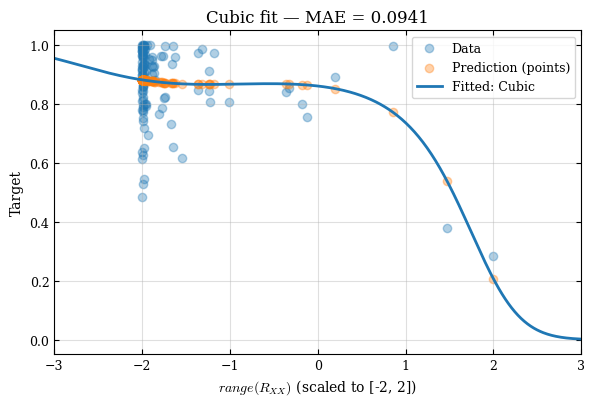

In [21]:
plot_best_fit(
    df_func_results=df_func_results,
    x=x,
    y=y,
    candidate_funcs=CANDIDATE_FUNCS,
    best_feat=best_feat,
)
plt.show()

## Distribution of Target

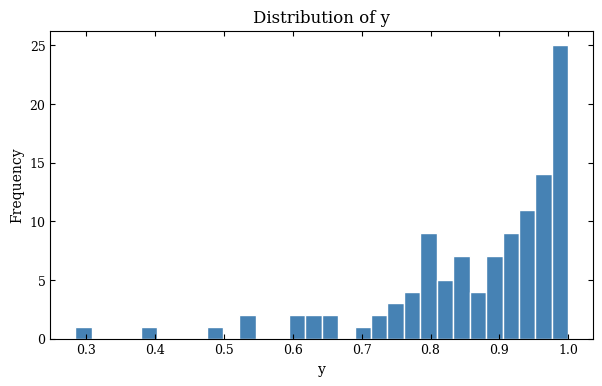

In [112]:
plt.figure(figsize=(7,4))
plt.hist(y, bins=30, color="steelblue", edgecolor="white")
plt.title("Distribution of y")
plt.xlabel("y")
plt.ylabel("Frequency")
plt.show()

## Feature importances

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from src.constants import ALGORITHM_PERFORMANCE_PATH, META_FEATURES_PATH
import shap

def plot_global_shap_importance(
    random_state: int,
    target: str,
    test_algorithm_file: str,
):
    algorithm_performance = pd.read_csv(ALGORITHM_PERFORMANCE_PATH / test_algorithm_file, index_col=0)
    meta_features = pd.read_csv(META_FEATURES_PATH, index_col=0)

    if target == "mean_accuracy":
        y_df = pd.DataFrame({"mean_accuracy": algorithm_performance.mean(axis=1)})
    elif target == "std_accuracy":
        y_df = pd.DataFrame({"std_accuracy": algorithm_performance.std(axis=1)})
    
    df = meta_features.merge(y_df, left_index=True, right_index=True, how="inner")

    X_all = df.drop(columns=[target])
    y = df[target].to_numpy()

    X_train, X_test, y_train, y_test = train_test_split(
        X_all, y, test_size=0.2, random_state=random_state
    )
    rf = RandomForestRegressor(random_state=42)
    rf.fit(X_train, y_train)

    explainer = shap.TreeExplainer(rf, feature_names=X_all.columns)
    shap_values = explainer.shap_values(X_test)
    mean_abs_shap = np.abs(shap_values).mean(axis=0)

    df_importance = pd.DataFrame({
        "feature": X_all.columns,
        "mean_abs_shap": mean_abs_shap
    }).sort_values("mean_abs_shap", ascending=True)

    plt.figure(figsize=(8, 0.35 * len(df_importance) + 1))
    plt.barh(
        y=np.arange(len(df_importance))[::-1],
        width=df_importance["mean_abs_shap"].values[::-1],
        color="steelblue"
    )
    plt.yticks(np.arange(len(df_importance))[::-1], df_importance["feature"].values[::-1])
    plt.xlabel("Mean |SHAP value|")
    plt.title(f"Globale Feature Importance (SHAP) for {target}")
    plt.tight_layout()
    plt.show()

    return df_importance

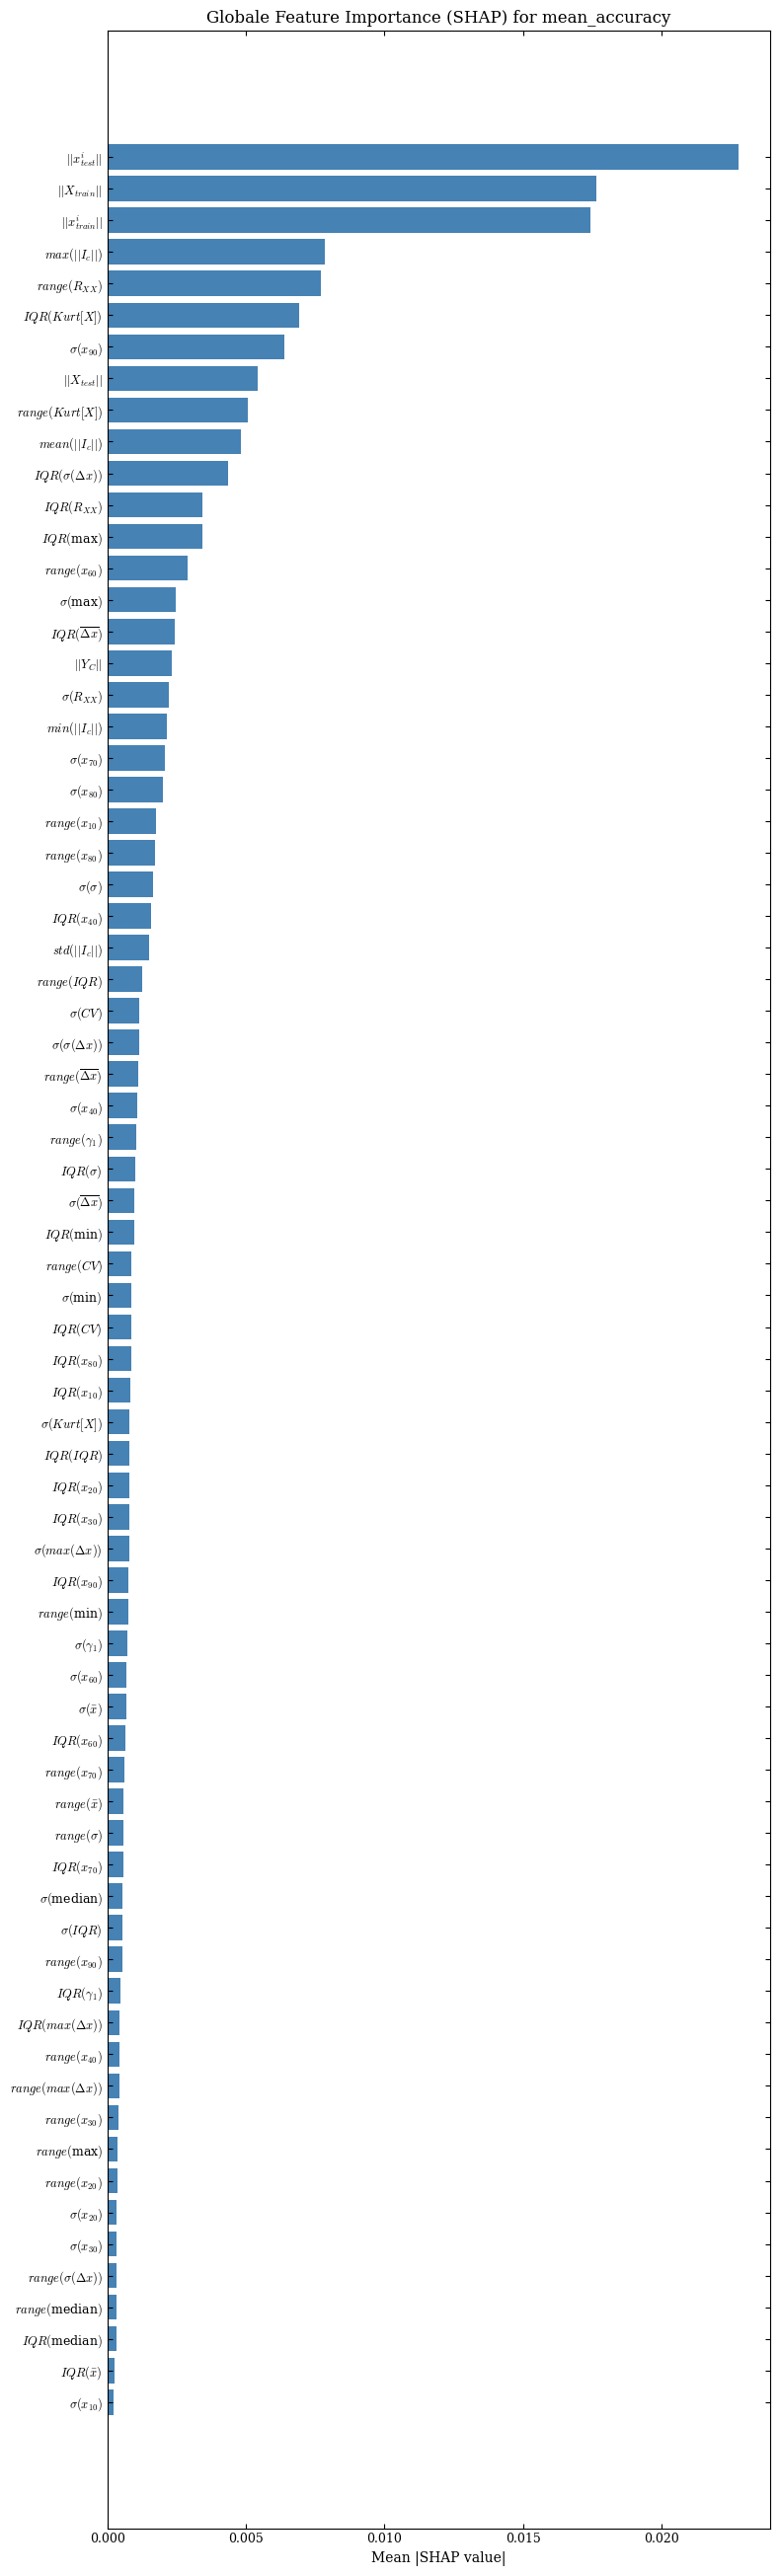

,feature,mean_abs_shap
9,$\sigma ($$x_{10}$$)$,0.000228
2,$IQR ($$\bar{x}$$)$,0.000246
23,$IQR ($median$)$,0.000316
22,$range ($median$)$,0.000316
52,$range ($$\sigma(\Delta x)$$)$,0.000318


In [123]:
df_shap_importance = plot_global_shap_importance(
    test_algorithm_file="ROCKET_ACC.csv",
    target="mean_accuracy",
    random_state=42,
)

df_shap_importance.head()


## Function for multiple features

In [ ]:
def make_sparse_sigmoid_function(
    p: int,
    seed: int = 42,
    max_active: int = 11,
) -> tuple[Callable[[np.ndarray], np.ndarray], dict]:
    
    rng = np.random.default_rng(seed)
    s = min(p, max_active)

    # Define weights
    active = rng.choice(p, size=s, replace=False) if s > 0 else np.array([], int)
    weights = []
    # first weight very high impact
    if s >= 1: weights.append(1.00)
    # second and third weight with similar high impact
    if s >= 2: weights.append(0.60)
    if s >= 3: weights.append(0.55)
    # maximum 8 additional weights with decreasing impact
    if s > 3:
        k = min(8, s - 3)
        weights += np.linspace(0.30, 0.10, num=k).tolist()
    weights = np.array(weights[:s], float)
    weights *= rng.choice([-1.0, 1.0], size=s)

    # 50/50 linear vs. non-linear
    rng.shuffle(active)
    n_lin = s // 2
    lin_idx = active[:n_lin]
    non_idx = active[n_lin:]

    def make_linear():
        return (lambda x: x, "linear")

    def make_quadratic():
        return (lambda x: x**2, "quadratic")

    def make_cubic():
        return (lambda x: x**3, "cubic")

    def make_sin():
        return (lambda x: np.sin(x), "sin")

    def make_cos():
        return (lambda x: np.cos(x), "cos")

    def make_exp():
        return (lambda x: np.exp(x), "exp")

    NONLINEAR_FACTORIES = [make_quadratic, make_cubic, make_sin, make_cos, make_exp]

    # create terms
    terms = []
    for feature_index, weight in zip(lin_idx, weights[:len(lin_idx)]):
        fn, name = make_linear()
        terms.append((int(feature_index), fn, float(weight), name))
    for feature_index, weight in zip(non_idx, weights[len(lin_idx):]):
        factory = rng.choice(NONLINEAR_FACTORIES)
        fn, name = factory()
        terms.append((int(feature_index), fn, float(weight), name))

    # final function, bias controls that distribution of accuracy is realistic
    bias = 1.0
    def f(X: np.ndarray) -> np.ndarray:
        z = np.full(X.shape[0], bias, float)
        for i, fn, w, _ in terms:
            z += w * fn(X[:, i])
        return expit(z)

    info = {
        "p": p,
        "bias": float(bias),
        "active_indices": [i for (i, *_rest) in terms],
        "terms": [
            {"i": i, "weight": w, "name": name}
            for (i, _, w, name) in terms
        ],
        "seed": seed,
    }

    return f, info


[{'i': 5, 'weight': -1.0, 'name': 'linear'}, {'i': 1, 'weight': -0.6, 'name': 'linear'}, {'i': 10, 'weight': 0.55, 'name': 'linear'}]


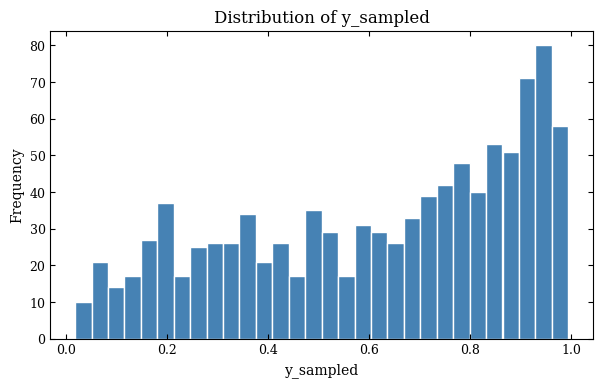

In [143]:
p = 20
f, info = make_sparse_sigmoid_function(p, seed=42)

X = np.random.default_rng(0).uniform(-2, 2, size=(1000, p))
y_hat = f(X)

print(info["terms"][:3])

plt.figure(figsize=(7,4))
plt.hist(y_hat, bins=30, color="steelblue", edgecolor="white")
plt.title("Distribution of y_sampled")
plt.xlabel("y_sampled")
plt.ylabel("Frequency")
plt.show()

## Sigma for multiple features